In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
from Libraries_functions import *
from tqdm import tqdm
import glob

In [9]:
def select_spectrograms(spectrograms,
                        file_paths,
                        min_max_values,
                        num_spectrograms=4):
    num_spec_each_class = int(num_spectrograms / 4)
    num_spec_each_class_rest = num_spec_each_class+ (num_spectrograms-num_spec_each_class*4)
    sampled_indexes_0 = np.random.choice(range(0,int(len(spectrograms)/4)-1), num_spec_each_class)
    sampled_indexes_1 = np.random.choice(range(int(len(spectrograms)/4),(int(len(spectrograms)/4)*2)-1), num_spec_each_class)
    sampled_indexes_2 = np.random.choice(range((int(len(spectrograms)/4)*2),(int(len(spectrograms)/4)*3)-1), num_spec_each_class_rest)
    sampled_indexes_3 = np.random.choice(range((int(len(spectrograms)/4)*3),(int(len(spectrograms)/4)*4)-1), num_spec_each_class)
    sampled_indexes=np.concatenate((sampled_indexes_0,sampled_indexes_1,sampled_indexes_2,sampled_indexes_3))
    sampled_spectrogrmas = spectrograms[sampled_indexes]
    file_paths = [file_paths[index] for index in sampled_indexes]
    sampled_min_max_values = [min_max_values[file_path] for file_path in
                           file_paths]
    print(file_paths)
    return sampled_spectrogrmas, sampled_min_max_values, file_paths

def load_form_dir(dir_path):
    train=[]
    file_paths=[]
    for root, _, filenames in os.walk(dir_path):
        for file_name in sorted(filenames, key=lambda x: (x.split("d")[2])): #TODO: mirar por que no se guardan en orden
            print(file_name)
            filepath= os.path.join(root, file_name)
            spectrogram=np.load(filepath)
            train.append(spectrogram)
            file_paths.append(filepath)
        train=np.array(train)
        train = train[..., np.newaxis]

    return train, file_paths

def load_min_max(min_max_path):
    with open (min_max_path, "rb") as f:
        min_max_values = pickle.load(f)
    return min_max_values

def save_signals(signals, save_dir,voice_paths,type, sample_rate=22050):
    py_files_m = glob.glob(f'{save_dir}*')
    for py_file in py_files_m:
        try:
            os.remove(py_file)
        except OSError as e:
            print(f"Error:{ e.strerror}")
    for i, signal in enumerate(signals):
        save_path = os.path.join(save_dir, type+voice_paths[i] + ".wav")
        sf.write(save_path, signal, sample_rate)

def preprocess_files():
    ## Ejecutar solo si no tenemos los tests generados correctamente

    py_files_m = glob.glob(f'{SPECTROGRAMS_SAVE_DIR}*')
    for py_file in py_files_m:
        try:
            os.remove(py_file)
        except OSError as e:
            print(f"Error:{ e.strerror}")

    py_files_m = glob.glob(f'{MIN_MAX_VALUES_SAVE_DIR}*')
    for py_file in py_files_m:
        try:
            os.remove(py_file) 
        except OSError as e:
            print(f"Error:{ e.strerror}")


    # instantiate all objects
    loader = Loader(SAMPLE_RATE, DURATION,MONO)
    padder = Padder()
    log_spectrogram_extractor = LogSpectrogramExtractor(N_FFT, HOP_LENGTH)
    min_max_normaliser = MinMaxNormaliser(0, 1)
    saver= Saver(SPECTROGRAMS_SAVE_DIR,MIN_MAX_VALUES_SAVE_DIR)

    preprocessing_pipeline = PreprocessingPipeline()
    preprocessing_pipeline.loader = loader
    preprocessing_pipeline.padder = padder
    preprocessing_pipeline.extractor = log_spectrogram_extractor
    preprocessing_pipeline.normaliser = min_max_normaliser
    preprocessing_pipeline.saver = saver

    preprocessing_pipeline.process(FILES_DIR)

def convert_spectrograms_to_audio(spectrograms, min_max_values, noise, files_path):
    _min_max_normaliser=MinMaxNormaliser(0, 1)
    signals = []
    path_signals=[]
    for spectrogram, min_max_value, files_path in zip(spectrograms, min_max_values, files_path):
        # reshape the log spectrogram
        log_spectrogram = spectrogram[:, :, 0]
        # apply denormalisation
        denorm_log_spec = _min_max_normaliser.denormalise(
            log_spectrogram, min_max_value["min"], min_max_value["max"])
        librosa.display.specshow(denorm_log_spec, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)## Nos permite visualizar como un mapa de calor
        name="mixed"if noise else "predicted"
        plt.title(f"{name}_Name:{files_path}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.show()
        # log spectrogram -> spectrogram
        spec = librosa.db_to_amplitude(denorm_log_spec)
        # apply Griffin-Lim
        _, phase= librosa.magphase(spec)
        #signal = librosa.istft(spec*phase, hop_length=self.hop_length)
        signal = librosa.istft(spec*min_max_value["mag_phase"], hop_length=HOP_LENGTH)

        # append signal to "signals"
        signals.append(signal)
        path_signals.append(files_path)
    return signals, path_signals

def spectrograms_of_voice(file_path):
    signals = []
    path_signals=[]
    for spectrogram in (file_path):
        signal_noise, sr_noise = librosa.load(spectrogram, sr=SAMPLE_RATE, mono=True)

        stft_mixed= librosa.stft(signal_noise, n_fft=N_FFT, hop_length=HOP_LENGTH)[:-1]
        spectrogram_mixed= np.abs(stft_mixed)
        log_spectrogram_mixed= librosa.amplitude_to_db(spectrogram_mixed)

        librosa.display.specshow(log_spectrogram_mixed, sr=SAMPLE_RATE, hop_length=HOP_LENGTH)## Nos permite visualizar como un mapa de calor
        plt.title(f"voice_{spectrogram}")
        plt.xlabel("Time")
        plt.ylabel("Frequency")
        plt.colorbar()
        plt.show()
        # append signal to "signals"
        signals.append(signal_noise)
        path_signals.append(spectrogram)
    return signals, path_signals

def search_voices(file_path):
    def know_number_spec(file_path):
        paths=[]
        for file in file_path:
            file_cut=file.split("d")[-1].split(".")[0]
            paths.append(file_cut)
        return paths

    def find_noise(mixed_numbers):
        voice_paths=[]
        py_files_m = glob.glob(f'{PATH_TO_VOICES}*')
        for py_file in py_files_m:
            file=(py_file.split("e")[-1].split(".")[0])
            if(file in mixed_numbers):
                voice_paths.append(py_file)
        return voice_paths
    mixed_numbers=know_number_spec(file_path)
    voice_paths=find_noise(mixed_numbers)
    print(voice_paths)
    return voice_paths


In [4]:
MONO = True
PATH_TO_MODEL= "../../models/"
PATH_TO_VOICES="../../Datasets/Test/voice/"
SPECTROGRAMS_SAVE_DIR = "../../Datasets/Data/tests/"
MIN_MAX_VALUES_SAVE_DIR = "../../Datasets/Data/min_max_tests/"
MIN_MAX_VALUES = "../../Datasets/Data/min_max_tests/min_max_values.pkl"
FILES_DIR = "../../Datasets/Test/mixed_sound/"
SAVE_DIR_ORIGINAL="../../Datasets/model_generated_VAE/original/"
SAVE_DIR_GENERATED="../../Datasets/model_generated_VAE/generated/"
SAVE_DIR_REAL="../../Datasets/model_generated_VAE/real/"

In [5]:
preprocess_files()

  8%|▊         | 15/200 [00:00<00:01, 143.94it/s]

Processed file ../../Datasets/Test/mixed_sound/mixed_sound10066.wav


100%|██████████| 200/200 [00:01<00:00, 137.98it/s]


## Cargamos el modelo y los datos

In [10]:
# model= VAE.load(PATH_TO_MODEL)

min_max_values= load_min_max(MIN_MAX_VALUES)
spectrograms, file_path = load_form_dir(SPECTROGRAMS_SAVE_DIR)
sampled_specs, sampled_min_max_values, file_path = select_spectrograms(spectrograms, file_path, min_max_values, num_spectrograms=6)
voice_paths= search_voices(file_path)

mixed_sound10066.wav.npy
mixed_sound10300.wav.npy
mixed_sound10564.wav.npy
mixed_sound10569.wav.npy
mixed_sound10753.wav.npy
mixed_sound1095.wav.npy
mixed_sound11166.wav.npy
mixed_sound11319.wav.npy
mixed_sound11428.wav.npy
mixed_sound12581.wav.npy
mixed_sound12771.wav.npy
mixed_sound12899.wav.npy
mixed_sound13025.wav.npy
mixed_sound13063.wav.npy
mixed_sound13281.wav.npy
mixed_sound13324.wav.npy
mixed_sound14181.wav.npy
mixed_sound14390.wav.npy
mixed_sound1479.wav.npy
mixed_sound1515.wav.npy
mixed_sound15336.wav.npy
mixed_sound15432.wav.npy
mixed_sound15597.wav.npy
mixed_sound16171.wav.npy
mixed_sound1635.wav.npy
mixed_sound16548.wav.npy
mixed_sound1690.wav.npy
mixed_sound17281.wav.npy
mixed_sound17386.wav.npy
mixed_sound17765.wav.npy
mixed_sound18314.wav.npy
mixed_sound18846.wav.npy
mixed_sound19017.wav.npy
mixed_sound19043.wav.npy
mixed_sound19072.wav.npy
mixed_sound1912.wav.npy
mixed_sound19212.wav.npy
mixed_sound19725.wav.npy
mixed_sound2015.wav.npy
mixed_sound20166.wav.npy
mixed_s

## load from vae_auto_propio

In [21]:
model_name="VAE_weights_loss_1327.4_alpha_100000_dim_350"
alpha=100000
latent=350
learning_rate=0.0001

# vae=VAE.load_model_complete(sampled_specs,alpha,latent, learning_rate)
vae=VAE.load_model(sampled_specs,alpha,latent, learning_rate)

vae= VAE.load_model_weights(vae, save_folder= PATH_TO_MODEL, name=model_name)

signals=vae.predict(sampled_specs)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 128, 128, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_11 (Conv2D)             (None, 64, 64, 128)  73856       ['conv2d_10[0][0]']              
                                                                                            

d:\Anaconda\envs\Javier_waveinet\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


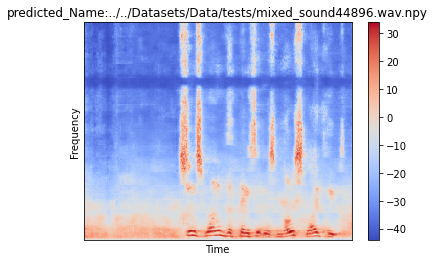

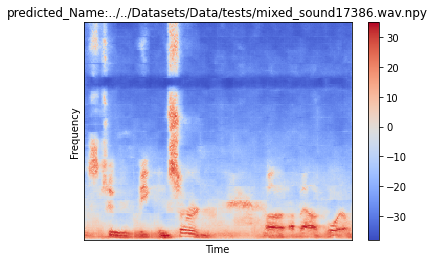

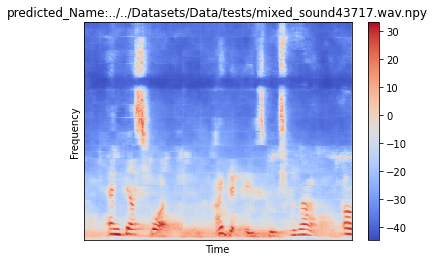

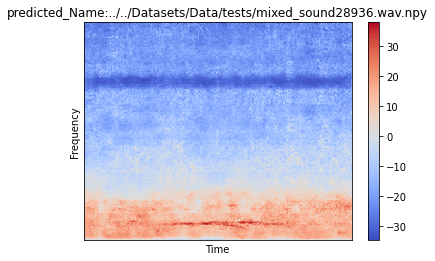

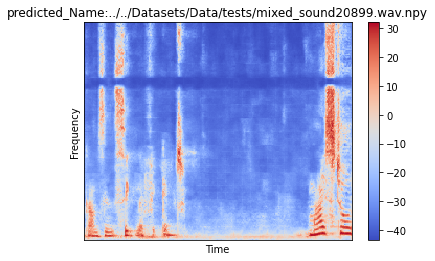

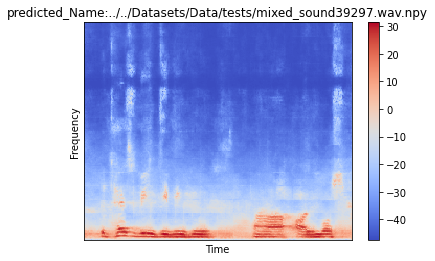

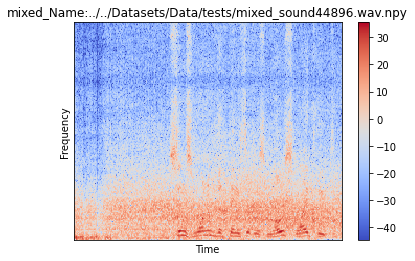

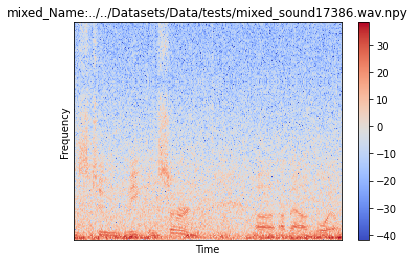

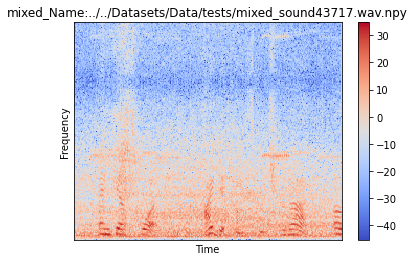

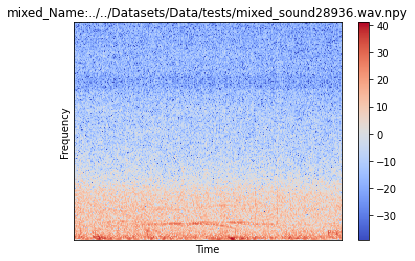

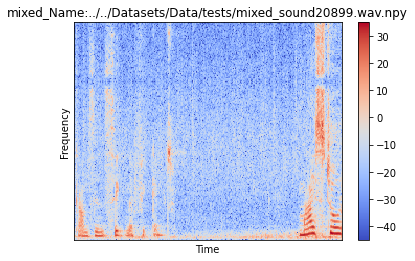

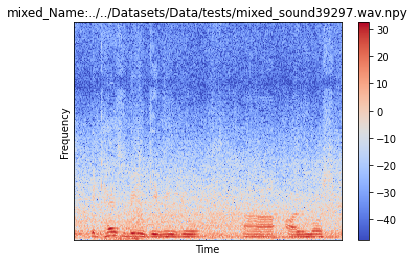

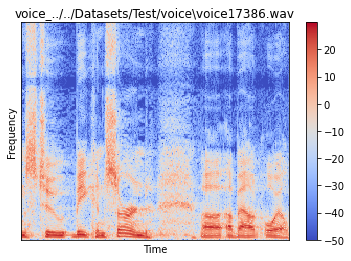

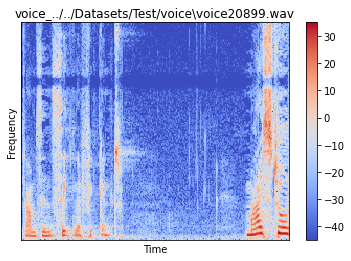

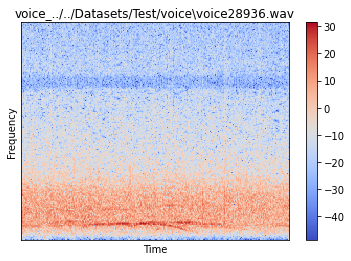

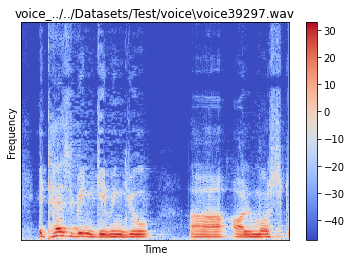

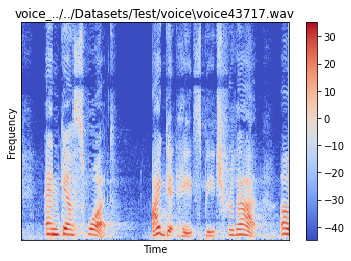

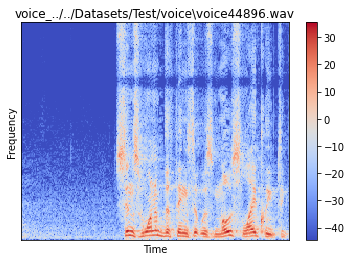

In [22]:
new_signals, predicted_path = convert_spectrograms_to_audio(
    signals, sampled_min_max_values,False,file_path )

original_signals, mixed_path = convert_spectrograms_to_audio(
    sampled_specs, sampled_min_max_values,True, file_path)

real_signals, real_path=spectrograms_of_voice(voice_paths)

In [23]:
for i in range(len(predicted_path)):
    predicted_path[i]=predicted_path[i].split("d")[-1].split(".")[0]
for i in range(len(mixed_path)):
    mixed_path[i]=mixed_path[i].split("d")[-1].split(".")[0]
for i in range(len(real_path)):
    real_path[i]=real_path[i].split("e")[-1].split(".")[0]

In [24]:
save_signals(new_signals, SAVE_DIR_GENERATED, predicted_path, "predicted_")
save_signals(original_signals, SAVE_DIR_ORIGINAL, mixed_path, "mixed_")
save_signals(real_signals, SAVE_DIR_REAL, real_path, "real_")